In [1]:
import warnings
warnings.filterwarnings("ignore")

#### IMPORTING REQUIRED LIBRARIES

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor

#### IMPORTING DATASET INTO THE DATAFRAME

In [3]:
df = pd.read_excel("premiums.xlsx")

In [4]:
df.head(3)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164


In [5]:
df.shape

(50000, 13)

In [6]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount'],
      dtype='object')

#### MAKING FEATURE NAMING CONSISTENT

In [7]:
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.head(1)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053


#### DATA CLEANING - HANDLING MISSING VALUES

In [8]:
df.isna().sum()
#NA rows are less and we have abundant data so we will choose to simply drop these rows

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

In [9]:
df.dropna(inplace = True)

In [10]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [11]:
df.duplicated().sum()
#df.drop_duplicates(inplace = True) #enable if we have duplicates in new dataset when added on same notebook

np.int64(0)

#### DATA CLEANING - EDA

In [12]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.711842,23.021150,15766.810189
std,15.000378,1.498195,24.221794,8419.995271
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


In [13]:
# The column number_of_dependants has negative value, we'll fix it first

In [14]:
df[df.number_of_dependants<0].shape

(72, 13)

In [15]:
df[df.number_of_dependants<0]['number_of_dependants'].unique()

array([-3, -1])

In [16]:
# Could be an error in scraping script that it input values as negative in number_of_dependants column
# So i decided here not to drop the rows but convert them to absolute values

In [17]:
df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    49976.000000
mean         1.717284
std          1.491953
min          0.000000
25%          0.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

#### DATA CLEANING - TREATING OUTLIERS

In [18]:
numeric_columns = df.select_dtypes(['int64', 'float64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

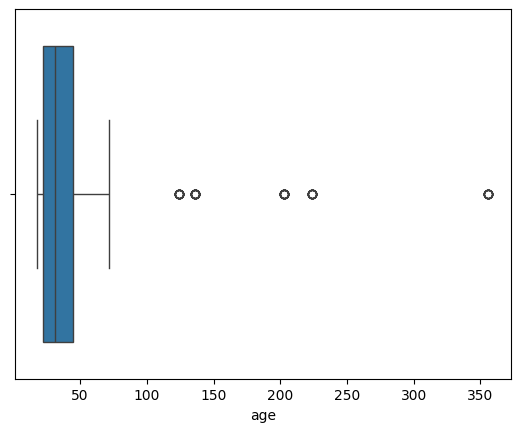

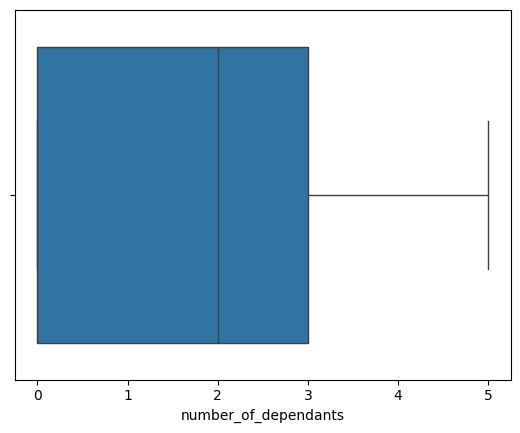

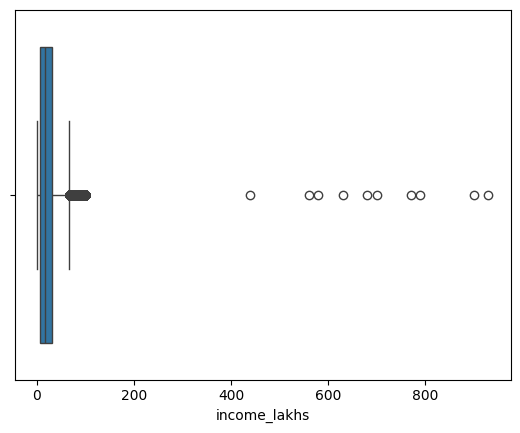

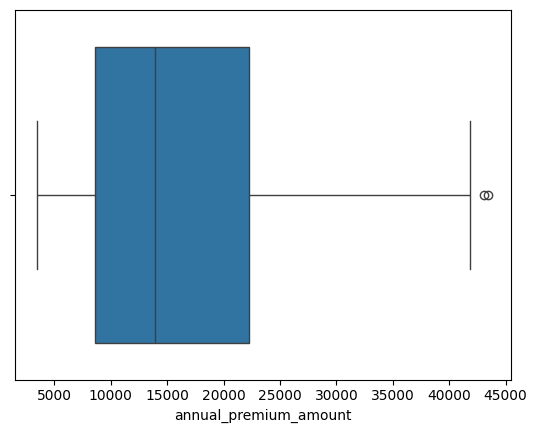

In [19]:
for col in numeric_columns:
    sns.boxplot(x=df[col])
    plt.show()

#### TREATING 'age' COLUMN

In [20]:
df[df.age>100]['age'].unique()

array([224, 124, 136, 203, 356])

In [21]:
df_age_fixed = df[df.age<=100].copy()
df_age_fixed.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49918.000000,49918.000000,49918.000000,49918.000000
mean,34.401839,1.717617,23.025141,15766.589286
std,13.681600,1.492074,24.227912,8419.137327
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22272.000000
max,72.000000,5.000000,930.000000,43471.000000


#### TREATING 'income_lakhs' COLUMN

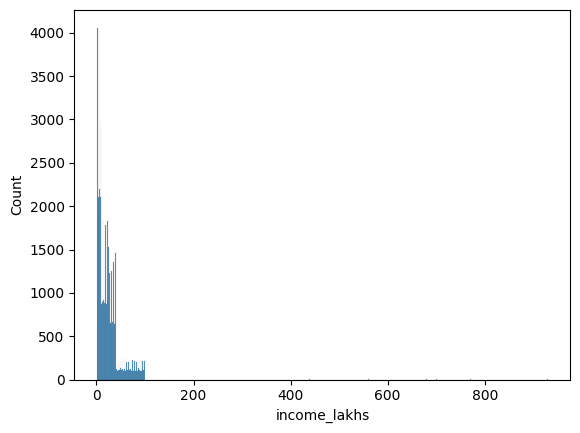

In [22]:
sns.histplot(df_age_fixed.income_lakhs)
plt.show()

In [23]:
df_age_fixed.income_lakhs.quantile([0.25, 0.75])

0.25     7.0
0.75    31.0
Name: income_lakhs, dtype: float64

In [24]:
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

In [25]:
quantile_threshold_income = df_age_fixed.income_lakhs.quantile(0.999)
quantile_threshold_income

np.float64(100.0)

In [26]:
df_income_fixed = df_age_fixed[df_age_fixed.income_lakhs<=quantile_threshold_income].copy()

In [27]:
df_income_fixed.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49908.000000,49908.000000,49908.000000,49908.000000
mean,34.401579,1.717640,22.889897,15765.739641
std,13.681604,1.492032,22.170699,8418.674061
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22270.500000
max,72.000000,5.000000,100.000000,43471.000000


In [28]:
# df_income_fixed is our latest df

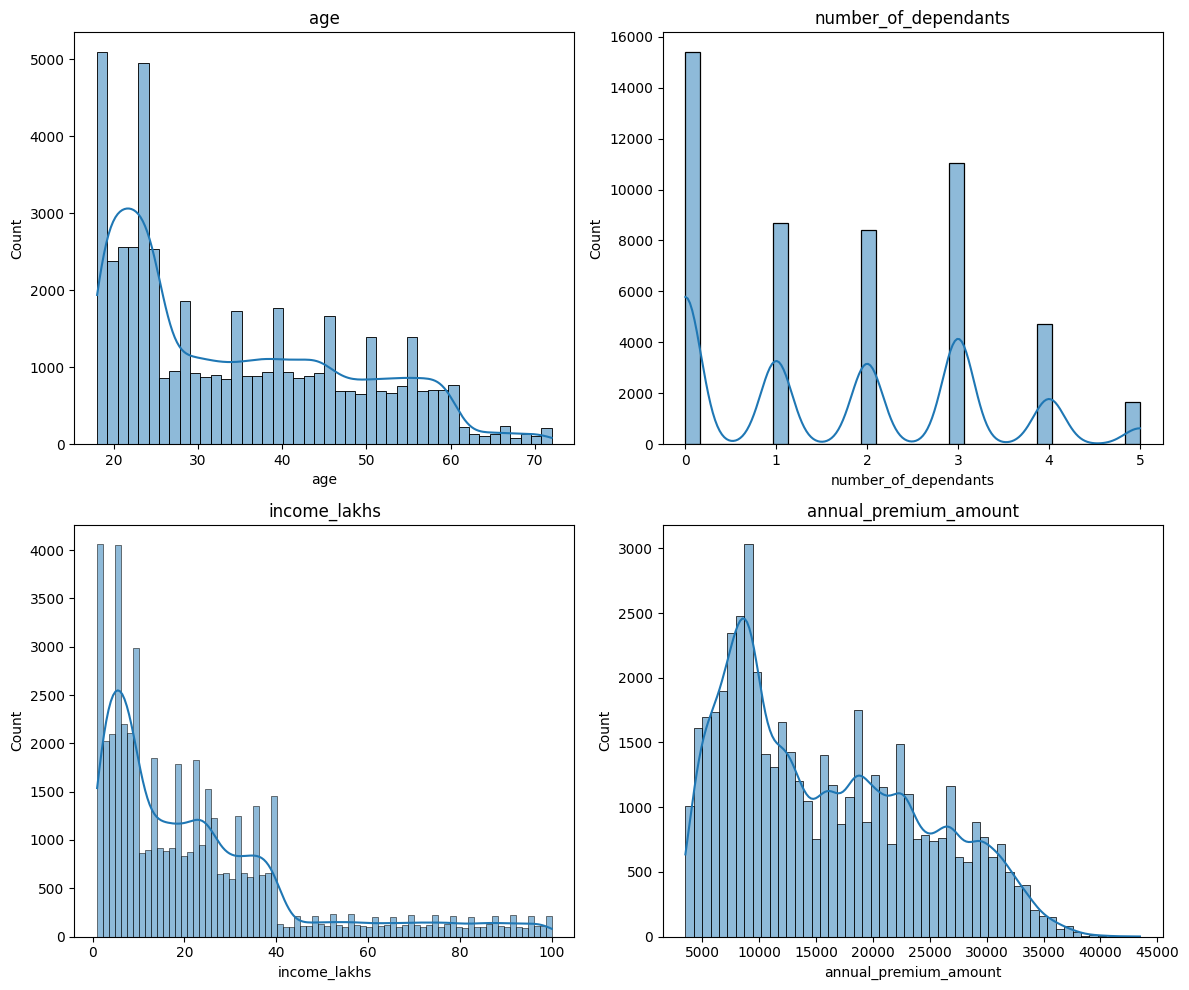

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.histplot(df_income_fixed[col], kde=True, ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()


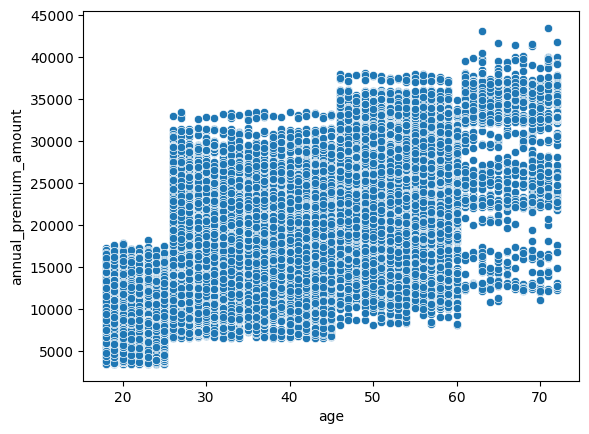

In [30]:
sns.scatterplot(df_income_fixed, x = 'age', y = 'annual_premium_amount')
plt.show()

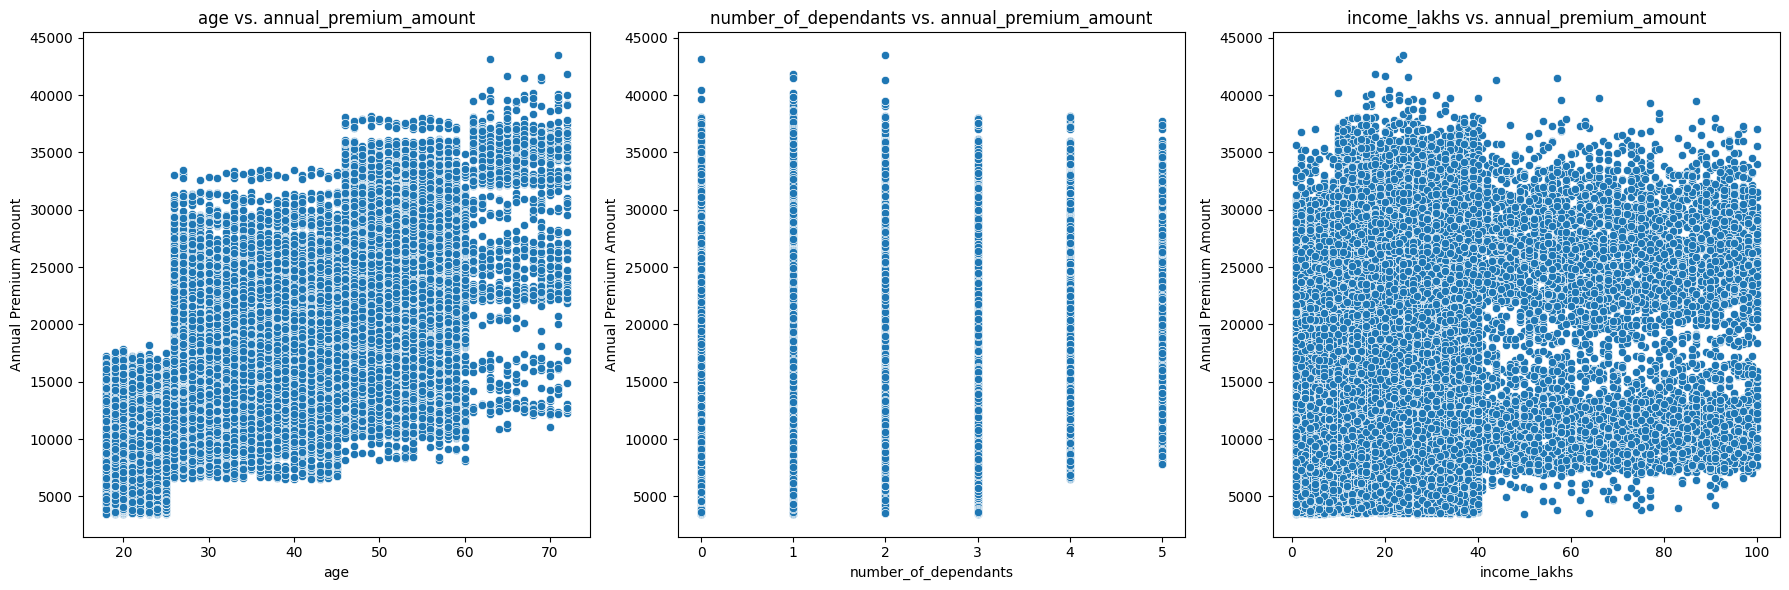

In [32]:
fig, axes = plt.subplots(1, (len(numeric_columns)-1), figsize = (18,6))

for ax, column in zip(axes, numeric_columns):
    sns.scatterplot(x = df_income_fixed[column], y = df_income_fixed['annual_premium_amount'], ax=ax)
    ax.set_title(f'{column} vs. annual_premium_amount')
    ax.set_xlabel(column)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()
plt.show()

In [33]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
categorical_columns

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')